# Model calibration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

## Titanic Dataset Description:

The **Titanic** data set contain different information about passengers onboard the Titanic, and we see if we can use that information to predict whether those people survived or not.

Features:
* survival - Survival (0 = No; 1 = Yes)
* class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* name - Name
* sex - Sex
* age - Age
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* ticket - Ticket Number
* fare - Passenger Fare
* cabin - Cabin
* embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [2]:
# Importing dataset
titanic = pd.read_csv("Data/titanic.csv")

# Convert categorical variable to numeric
titanic["Sex_cleaned"]=np.where(titanic["Sex"]=="male",0,1)
titanic["Embarked_cleaned"]=np.where(titanic["Embarked"]=="S",0,
                                  np.where(titanic["Embarked"]=="C",1,
                                           np.where(titanic["Embarked"]=="Q",2,3)
                                          )
                                 )
# Cleaning dataset of NaN
titanic_cleaned = titanic[[
    "Survived",
    "Pclass",
    "Sex_cleaned",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "Embarked_cleaned"
]].dropna(axis=0, how='any').copy()

print(titanic_cleaned.shape)
titanic_cleaned.head()

(714, 8)


,Survived,Pclass,Sex_cleaned,Age,SibSp,Parch,Fare,Embarked_cleaned
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


## Build a logistic regression classiciation model

In [3]:
features =[
    "Pclass",
    "Sex_cleaned",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "Embarked_cleaned"
]

train, test = train_test_split(titanic_cleaned, test_size=0.3, random_state=42)

# init a new logistic regression model
lr = LogisticRegression(random_state=1)
lr = lr.fit(train[features], train["Survived"])
lr

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Estimate model calibration

### Calibration curve drawing function

In [4]:
def plot_calibration_curve(y_test, y_pred, name, fig_index):
    """Plot calibration curve for est. """


    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    clf_score = brier_score_loss(y_test, y_pred, pos_label=y_test.max())

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, y_pred, n_bins=10)

    print("Mean predicted points: {}".format(mean_predicted_value))
    print("Fraction of positives: {}".format(fraction_of_positives))
       
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (Brier: %1.3f)" % (name, clf_score))

    ax1.axvline(0.7535793, 0, 1, color='k', linestyle='--', c="red")

    ax2.hist(y_pred, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    print("\n \t%s Brier score: %1.3f" % (name, clf_score))

    plt.tight_layout()

### Predicting and assessing model calibration

Mean predicted points: [0.07656722 0.13671461 0.24237639 0.34365979 0.45762325 0.55980851
 0.64188236 0.7535793  0.84929644 0.93748158]
Fraction of positives: [0.2        0.10909091 0.21428571 0.44444444 0.4375     0.44444444
 0.61111111 0.64285714 0.94444444 0.94444444]

 	Logistic regression Brier score: 0.157


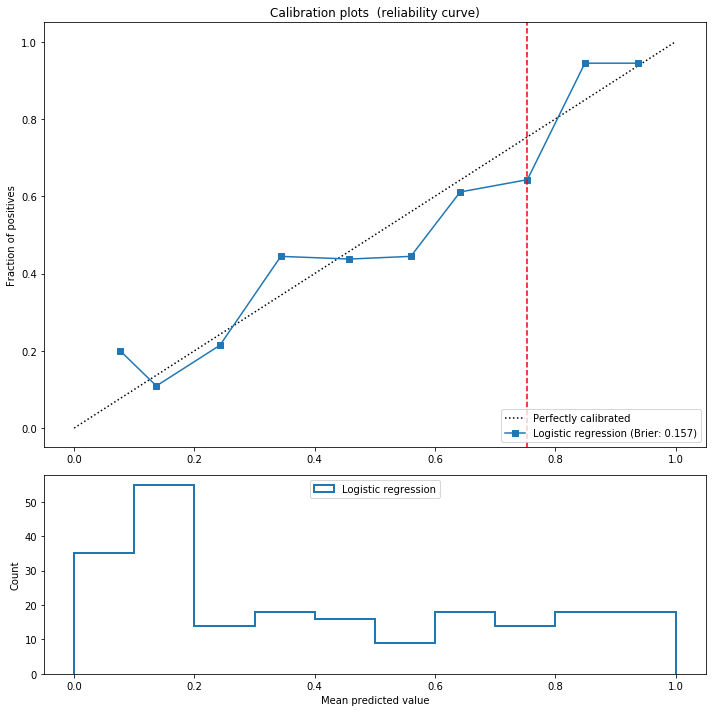

In [5]:
# predict
lr_prob_predict = lr.predict_proba(test[features])

y_test = test["Survived"]==1
y_pred = lr_prob_predict[:,1]


# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(y_test, y_pred, "Logistic regression", 1)
plt.show()